Análisis del precio de la electricidad usando LightGBM y CQR

In [1]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error,mean_absolute_percentage_error
from epftoolbox.evaluation import rMAE
from mapie.metrics import (regression_coverage_score,
                           regression_mean_width_score)
from jupyterthemes import jtplot


jtplot.style(theme='grade3', context='notebook', ticks=True, grid=False)
sns.set()
warnings.filterwarnings("ignore")

Curated data retrieved from CENACE

In [2]:
precio = pd.read_csv('Gas_PML_Daily_2018_22.csv')

Train, test data splitting

In [3]:
data = precio.copy()
data = data.drop(columns=['Demanda','Fotovoltaica','Hidroelectrica','Eolica'])
data['Date'] =  pd.to_datetime(data['Date'],dayfirst=True)
data = data.set_index('Date')

train = data.loc[(data.index >= '2020-01-02') & (data.index <= '2021-12-31')]
test = data.loc[(data.index >= '2022-01-01') & (data.index <= '2022-12-31')]

testfinal = data.loc[(data.index >= '2022-01-01') & (data.index <= '2022-12-31')]
testfinal = testfinal.drop(columns=['Precio Gas'])

Functions for exogenous variables definition and statistical metrics calculation

In [4]:
def create_features(df):
    df = df.copy()
    df['Gas'] = df['Precio Gas']
    return df

In [5]:
def calculate_model_accuracy_metrics(actual, predicted):
    mape = mean_absolute_percentage_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    rmae = rMAE(actual, predicted, m='W', freq='1H')
    smape = 100/len(actual) * np.sum(2 * np.abs(actual - predicted) / (np.abs(actual) + np.abs(predicted)))
    return mape*100,mae,mse,rmse,smape,rmae

In [6]:
def add_lags(df):
    df['lag1'] = df['Precio Electricidad'].shift(1)
    df['lag7'] = df['Precio Electricidad'].shift(7)
    return df

In [7]:
from mapie.regression import MapieTimeSeriesRegressor
from mapie.subsample import BlockBootstrap
from sklearn.preprocessing import StandardScaler

Creating exogenous features and adding lags for LGBM

In [8]:
trainlgbm = create_features(train)
testlgbm = create_features(test)

trainlgbm = add_lags(trainlgbm)
testlgbm = add_lags(testlgbm)

FEATURES = ['Gas','lag1','lag7']
TARGET = ['Precio Electricidad']

X_train = trainlgbm[FEATURES]
y_train = trainlgbm[TARGET]

X_test = testlgbm[FEATURES]
y_test = testlgbm[TARGET]

Data scaling

In [9]:
scaler = StandardScaler()
X_trainscaled = scaler.fit_transform(X_train)
y_trainscaled = scaler.fit_transform(y_train)

X_testscaled  = scaler.fit_transform(X_test)
y_testscaled  = scaler.fit_transform(y_test)

In [10]:
modelLGBM = LGBMRegressor(objective='regression',
                       metric='mse',
                        linear_tree=True,
                        learning_rate=0.0033,
                        max_depth=11,
                        num_leaves=1580,
                        max_bin=273,
                        min_child_samples=205,
                        n_estimators= 7823,
                        random_state = 101)
modelLGBM.fit(X_trainscaled, y_trainscaled)

LGBMRegressor(learning_rate=0.0033, linear_tree=True, max_bin=273, max_depth=11,
              metric='mse', min_child_samples=205, n_estimators=7823,
              num_leaves=1580, objective='regression', random_state=101)

Generate a point forecast on test data

In [11]:
y_pred = modelLGBM.predict(X_testscaled)
invert_pred = scaler.inverse_transform(y_pred.reshape(-1,1))
final_pred = testfinal.copy()
final_pred['pred'] = invert_pred

Plotting point forecast

(18993.0, 19357.0)

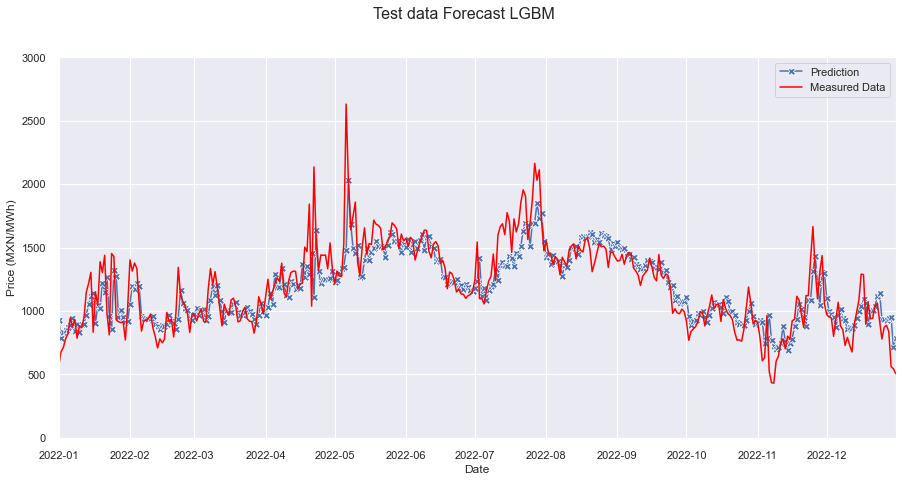

In [12]:
fig, (ax1) = plt.subplots(figsize=(15,7),sharex=True)
fig.suptitle('Test data Forecast LGBM', fontsize=16)
sns.lineplot(ax=ax1,x=final_pred.index,y=final_pred['pred'],label='Prediction',marker = 'X',markersize=7).set(ylabel = "Price (MXN/MWh)")
sns.lineplot(ax=ax1,x=final_pred.index,y=final_pred['Precio Electricidad'],label='Measured Data', color='red')
ax1.legend(loc='upper right')
ax1.set_ylim([0, 3000])
ax1.set_xlim([datetime.date(2022, 1, 1), datetime.date(2022,12,31)])

Using conformal prediction for prediction intervals calculation

In [13]:
alpha = 0.05
gap = 1

mapie_cv = BlockBootstrap(n_blocks=10, overlapping=True, random_state=42)

mapie_enbpi = MapieTimeSeriesRegressor(
    modelLGBM, method="enbpi", cv=mapie_cv, agg_function="mean", n_jobs=1
)

In [14]:
mapie_enbpi = mapie_enbpi.fit(X_trainscaled, y_trainscaled.ravel())
y_pred_npfit, y_pis_npfit = mapie_enbpi.predict(
    X_testscaled, alpha=alpha, ensemble=True, optimize_beta=True
)

In [15]:
df_X_testscaled = pd.DataFrame(X_testscaled, columns = X_test.columns)
df_y_testscaled = pd.DataFrame(y_testscaled, columns = y_test.columns)

In [16]:
mapie_enbpi2 = mapie_enbpi.fit(X_trainscaled, y_trainscaled.ravel())

y_pred_pfit = np.zeros(y_pred_npfit.shape)
y_pis_pfit = np.zeros(y_pis_npfit.shape)
conformity_scores_pfit = []
lower_quantiles_pfit = []
higher_quantiles_pfit = []
y_pred_pfit[:gap], y_pis_pfit[:gap, :, :] = mapie_enbpi2.predict(
    df_X_testscaled.iloc[:gap, :], alpha=alpha, ensemble=True, optimize_beta=True
)
for step in range(gap, len(X_test), gap):
    mapie_enbpi2.partial_fit(
        df_X_testscaled.iloc[(step - gap) : step, :],
        df_y_testscaled.iloc[(step - gap) : step],
    )
    (
        y_pred_pfit[step : step + gap],
        y_pis_pfit[step : step + gap, :, :],
    ) = mapie_enbpi2.predict(
        df_X_testscaled.iloc[step : (step + gap), :],
        alpha=alpha,
        ensemble=True,
        optimize_beta=True,
    )
    conformity_scores_pfit.append(mapie_enbpi2.conformity_scores_)
    lower_quantiles_pfit.append(mapie_enbpi2.lower_quantiles_)
    higher_quantiles_pfit.append(mapie_enbpi2.higher_quantiles_)

In [17]:
unscaled_pred_pfit = scaler.inverse_transform(y_pred_pfit.reshape(-1,1))
unscaled_pred_lowlim_pfit = scaler.inverse_transform(y_pis_pfit[:, 0, 0].reshape(-1,1))
unscaled_pred_uplim_pfit = scaler.inverse_transform(y_pis_pfit[:, 1, 0].reshape(-1,1))

final_unscaled = testfinal.copy()
final_unscaled['pred_pfit'] = unscaled_pred_pfit
final_unscaled['pred_uplim_pfit'] = unscaled_pred_uplim_pfit
final_unscaled['pred_lowlim_pfit'] = unscaled_pred_lowlim_pfit

In [18]:
coverage_pfit = regression_coverage_score(y_test, unscaled_pred_lowlim_pfit, unscaled_pred_uplim_pfit)
width_pfit = regression_mean_width_score(unscaled_pred_lowlim_pfit, unscaled_pred_uplim_pfit)

(18993.0, 19357.0)

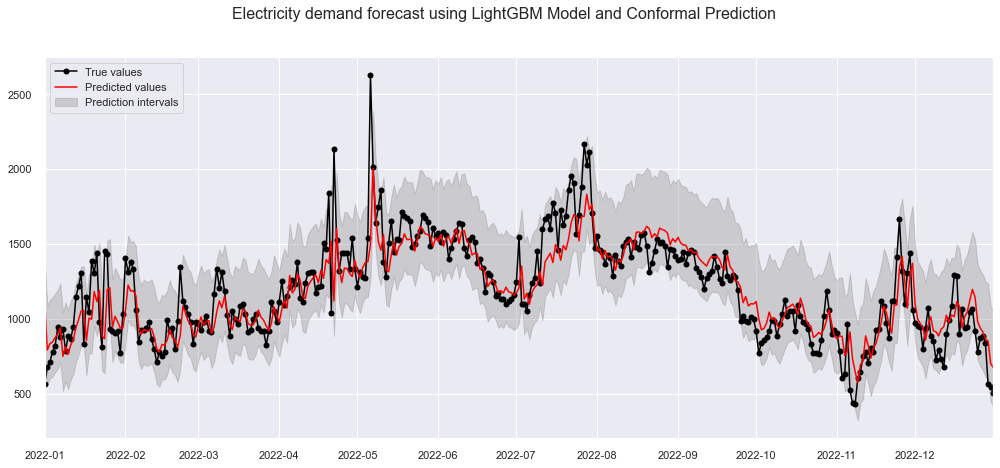

In [19]:
fig, (ax1) = plt.subplots(figsize=(17,7),sharex=True)
fig.suptitle('Electricity demand forecast using LightGBM Model and Conformal Prediction', fontsize=16)
ax1.plot(final_unscaled.index, final_unscaled['Precio Electricidad'], marker='o', label="True values", color='black')
ax1.plot(final_unscaled.index, final_unscaled['pred_pfit'].values, label="Predicted values", color='red')
ax1.fill_between(
    final_unscaled.index,
    final_unscaled['pred_uplim_pfit'].values,
    final_unscaled['pred_lowlim_pfit'].values,
    alpha=0.3,
    label="Prediction intervals",
    color='gray'
)
ax1.legend(loc='upper left')
ax1.set_xlim([datetime.date(2022, 1, 1), datetime.date(2022,12,31)])

In [20]:
from mapie.metrics import (regression_coverage_score,
                           regression_mean_width_score)

coverage = regression_coverage_score(final_unscaled['Precio Electricidad'].values,
            final_unscaled['pred_lowlim_pfit'].values, 
            final_unscaled['pred_uplim_pfit'].values)
width = regression_mean_width_score(final_unscaled['pred_lowlim_pfit'].values, final_unscaled['pred_uplim_pfit'].values)

In [21]:
pd.options.display.float_format = '{:.2f}'.format
PI_display = pd.DataFrame(data=(coverage, width), index=['Coverage', 'Width'])
PI_display.columns = ['Modelo LGBM-CP']
PI_display

,Modelo LGBM-CP
Coverage,0.94
Width,605.85
